### Competition Description
---

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

### Data Dictionary

| Variable  |    Definition       | Key   |
|-----------|:-------------------:|------:|
| survival  | Survival            | 0 = No, 1 = Yes           |
| pclass    | Ticket class        | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex       | Sex                 |       |
| Age       | Age in years        |       |
| sibsp     | # of siblings / spouses aboard the Titanic      |       |
| parch     | # of parents / children aboard the Titanic      |       |
| ticket    | Ticket number       |       |
| fare      | Passanger fare      |       |
| cabin     | Cabin number        |       |
| embarked  | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

### Data Overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df_train = pd.read_csv('Data/titanic_train.csv')
df_valid = pd.read_csv('Data/titanic_test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df_valid.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


First things first, let's drop some meaningless variables. But let's keep the ID for the submission.

In [7]:
df_ids = df_valid['PassengerId']
for df in [df_train, df_valid]:
    df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

### First Look at the Data

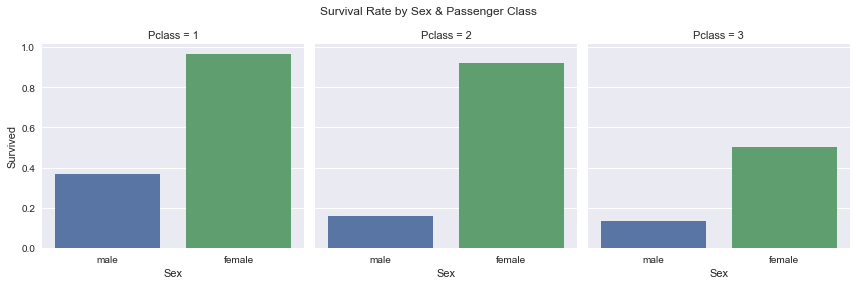

In [8]:
g = sns.factorplot(x='Sex', y='Survived', col='Pclass', data=df_train, kind='bar', ci=None)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Survival Rate by Sex & Passenger Class')

It's easy to note a that the majority of the survivors were women. Also, most of them, for both gender, were concentrated in `Pclass = 1`.

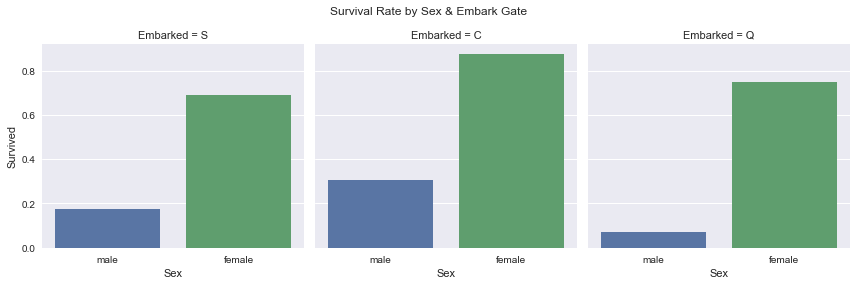

In [9]:
g = sns.factorplot(x='Sex', y='Survived', col='Embarked', data=df_train, kind='bar', ci=None)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Survival Rate by Sex & Embark Gate')

Here we can notice that for both men and women, the majority of survivors had `Embark = C`.

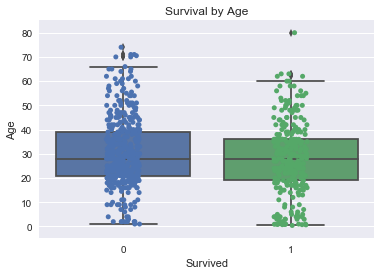

In [10]:
g = sns.boxplot(x='Survived', y='Age', data=df_train)
g = sns.stripplot(x='Survived', y='Age', data=df_train, jitter=True, edgecolor='gray')
sns.plt.title('Survival by Age')

Here we can see that, in general, the age doesn't say much about the chance of surviving or not. However, we can see that most of the oldest people died.

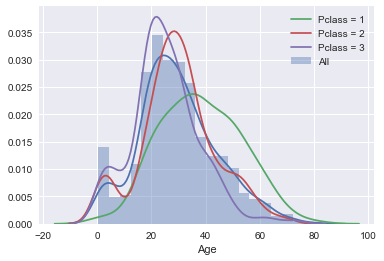

In [11]:
sns.distplot(df_train['Age'].dropna(), label='All')
sns.distplot(df_train[df_train['Pclass'] == 1]['Age'].dropna(), hist=False, label='Pclass = 1')
sns.distplot(df_train[df_train['Pclass'] == 2]['Age'].dropna(), hist=False, label='Pclass = 2')
sns.distplot(df_train[df_train['Pclass'] == 3]['Age'].dropna(), hist=False, label='Pclass = 3')

As the plot above shows, the age distribution among `Pclass` are similar, most of the people being middle-aged.

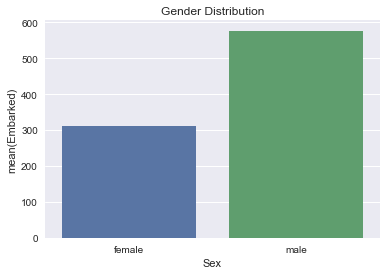

In [12]:
s = df_train.groupby(['Sex'], as_index=False)['Embarked'].count()
sns.barplot(x='Sex', y='Embarked', data=s)
sns.plt.title('Gender Distribution')

### Feature Engineering & Data Cleaning

In [13]:
df_both = pd.concat([df_train, df_valid])

* Features `Cabin`, `Age` and `Emabarked` have some missing values.
    * NaN `Cabin` will be filled according to the median value given the `Pclass` feature value
    * NaN `Age` will be filled according to its median value across the data set
    * NaN `Embarked` will be filled according to the median value given the `Pclass` feature value
    * NaN `Fare` will be filled according to its median
    * `Ticket` will be replaced by its first letter, indicative of the its placement
    
However, some pre-processing have to be done. First, for the `Cabin` feature, let's keep just the letter.

In [14]:
for df in [df_train, df_valid]: 
    df['Cabin'] = df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else x)

Now we are going to fill NaN values as specified above.

In [15]:
df_both = df_both.groupby(by=['Pclass', 'Cabin', 'Embarked'])['Sex'].count().to_frame().reset_index()

In [16]:
df_both = df_both.sort_values(['Sex', 'Pclass'], ascending=False).groupby(['Pclass']).first().reset_index()

In [17]:
df_both

,Pclass,Cabin,Embarked,Sex
0,1,C23 C25 C27,S,6
1,2,F2,S,4
2,3,G6,S,5


In [18]:
for df in [df_train, df_valid]:
    # Filling 'Cabin' according to 'Pclass'
    df.loc[(df['Pclass'] == 1) & (df['Cabin'].isnull()), 'Cabin'] = 'C'
    df.loc[(df['Pclass'] == 2) & (df['Cabin'].isnull()), 'Cabin'] = 'F'
    df.loc[(df['Pclass'] == 3) & (df['Cabin'].isnull()), 'Cabin'] = 'G'
    # Filling 'Embarked' according to 'Pclass'
    df['Embarked'].fillna('S', inplace=True)
    # Filling 'Age' by its median
    df['Age'].fillna(df['Age'].median(), inplace=True)
    # Filling 'Fare' by its median
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

Next, let's transform the `Fare` and `Age` features into categories

In [19]:
for df in [df_train, df_valid]:
    # Categorizing 'Ages'
    bins = (0, 5, 12, 18, 25, 35, 60, 120)
    names = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df['Age'], bins, labels=names)
    df['Age'] = categories
    # Categorizing 'Fare'
    names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile']    
    df['Fare'] = categories

In [20]:
for df in [df_train, df_valid]:
    df['Ticket'] = df['Ticket'].apply(lambda x: str(x)[0])

Now, let's perform some feature engineering. We are going to create two new features: 

* `FamilySize` is going to be given by the sum of `SibSp` and `Parch + 1`
* `IsAlone` is gonna be `1` if `FamilySize == 1` 

In [21]:
for df in [df_train, df_valid]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [22]:
for df in [df_train, df_valid]:    
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

Now, let's drop `Parch` and `SibSp`.

In [23]:
for df in [df_train, df_valid]:  
    df.drop(['Parch', 'SibSp'], axis=1, inplace=True)

### Digging Deeper

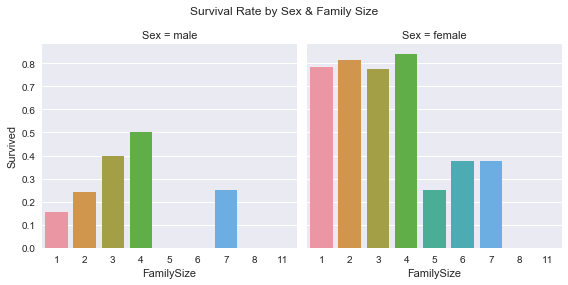

In [24]:
g = sns.factorplot(x='FamilySize', y='Survived', col='Sex', data=df_train, kind='bar', ci=None)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Survival Rate by Sex & Family Size')

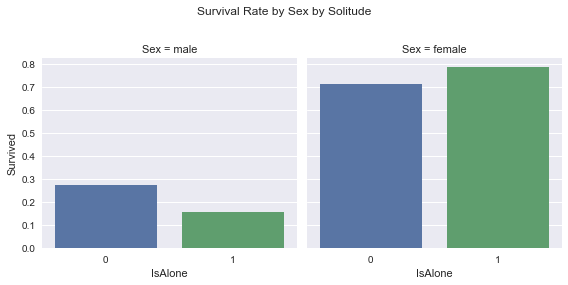

In [25]:
g = sns.factorplot(x='IsAlone', y='Survived', col='Sex', data=df_train, kind='bar', ci=None)
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival Rate by Sex by Solitude')

There are more men, however, more women survived.

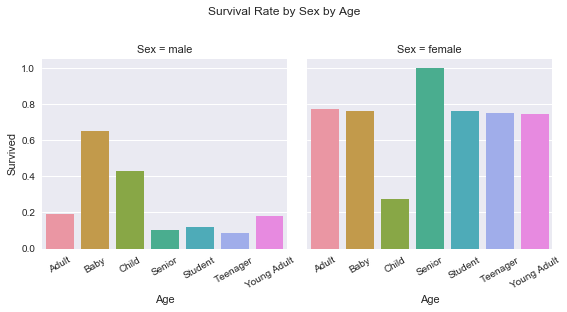

In [26]:
g = sns.factorplot(x='Age', y='Survived', col='Sex', data=df_train, kind='bar', ci=None)
plt.subplots_adjust(top=0.8)
g.set_xticklabels(rotation=30)
g.fig.suptitle('Survival Rate by Sex by Age')

In [27]:
df_train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,0,3,male,Student,A,Student,G,S,2,0
1,1,1,female,Adult,P,Adult,C,C,2,0
2,1,3,female,Young Adult,S,Young Adult,G,S,1,1
3,1,1,female,Young Adult,1,Young Adult,C,S,2,0
4,0,3,male,Young Adult,3,Young Adult,G,S,1,1


### Converting Categorical Features to Numeric

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
le = LabelEncoder()

categorical = ['Sex', 'Age', 'Ticket', 'Fare', 'Cabin', 'Embarked']

for df in [df_train, df_valid]:
    for cat in categorical:
        df[cat] = le.fit_transform(df[cat])

In [30]:
df_train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,0,3,1,4,9,4,6,2,2,0
1,1,1,0,0,13,0,2,0,2,0
2,1,3,0,6,14,6,6,2,1,1
3,1,1,0,6,0,6,2,2,2,0
4,0,3,1,6,2,6,6,2,1,1


### Last Look into the Data

Now that the data is fully numerical, we can take a look at the correlation among features.

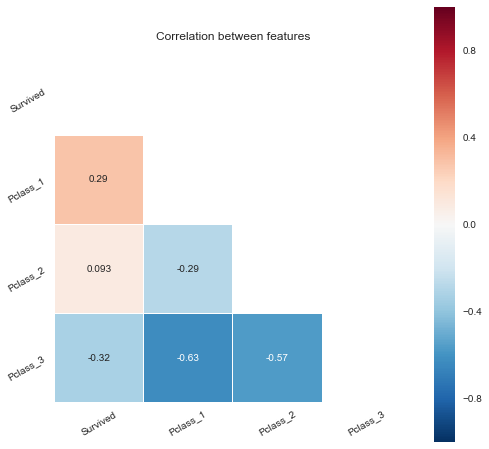

In [31]:
corr = pd.get_dummies(df_train[['Survived', 'Pclass']], columns=['Pclass']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8, 8))
with sns.axes_style('white'):
    sns.heatmap(corr, mask=mask, linewidths=0.01, square=True, annot=True, linecolor='white')
plt.yticks(rotation=30)
plt.xticks(rotation=30)
plt.title('Correlation between features')

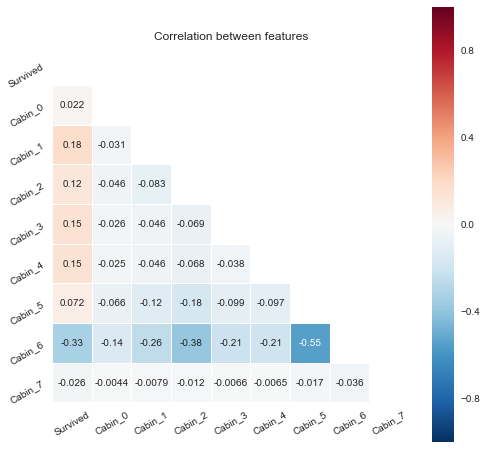

In [32]:
corr = pd.get_dummies(df_train[['Survived', 'Cabin']], columns=['Cabin']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8, 8))
with sns.axes_style('white'):
    sns.heatmap(corr, mask=mask, linewidths=0.01, square=True, annot=True, linecolor='white')
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Correlation between features')

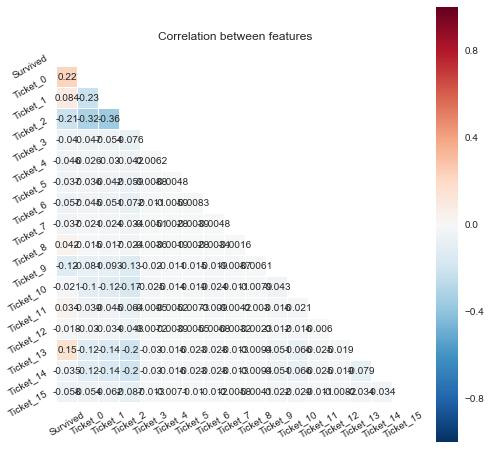

In [33]:
corr = pd.get_dummies(df_train[['Survived', 'Ticket']], columns=['Ticket']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8, 8))
with sns.axes_style('white'):
    sns.heatmap(corr, mask=mask, linewidths=0.01, square=True, annot=True, linecolor='white')
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Correlation between features')

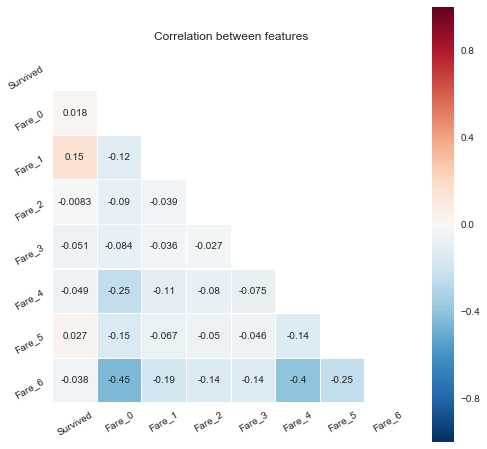

In [34]:
corr = pd.get_dummies(df_train[['Survived', 'Fare']], columns=['Fare']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8, 8))
with sns.axes_style('white'):
    sns.heatmap(corr, mask=mask, linewidths=0.01, square=True, annot=True, linecolor='white')
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Correlation between features')

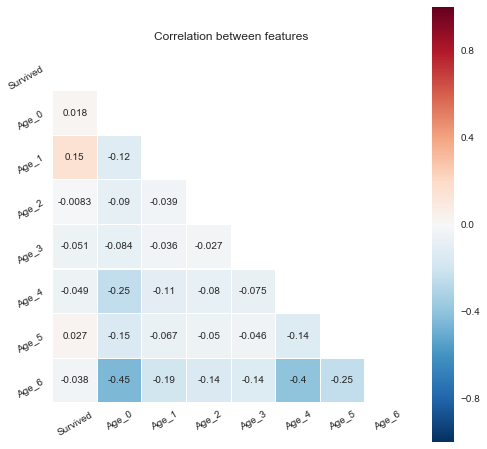

In [35]:
corr = pd.get_dummies(df_train[['Survived', 'Age']], columns=['Age']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8, 8))
with sns.axes_style('white'):
    sns.heatmap(corr, mask=mask, linewidths=0.01, square=True, annot=True, linecolor='white')
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Correlation between features')

### Testing Models

While we are working with categorical data, I'll try the Random Forest, Decision Tree and Gradient Boosting Classifies. To make use of linear models, it is a **MUST** to apply the pandas `get_dummies` method on the categorical features.

In [36]:
X_train = df_train.drop(['Survived'], axis=1)
y_train = df_train['Survived']
X_valid = df_valid

In [37]:
def plot_importances(clf, features):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), features[indices], rotation=30)
    plt.xlim([-1, len(importances)])
    plt.show()

In [38]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, y_train)
print('Score: %0.2f' % (clf_rf.score(X_train, y_train) * 100))

Score: 90.57


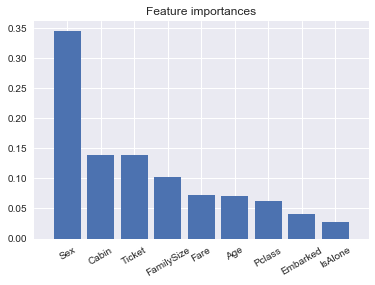

In [39]:
plot_importances(clf_rf, X_train.columns.values)

In [40]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
print('Score: %0.2f' % (clf_dt.score(X_train, y_train) * 100))

Score: 90.57


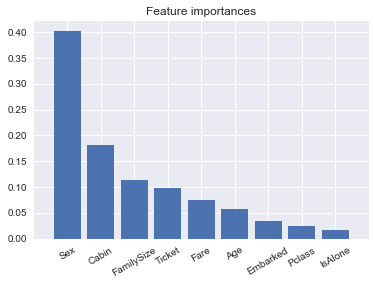

In [41]:
plot_importances(clf_dt, X_train.columns.values)

In [42]:
# Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)
print('Score: %0.2f' % (clf_gb.score(X_train, y_train) * 100))

Score: 86.08


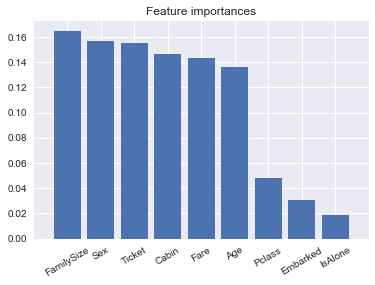

In [43]:
plot_importances(clf_gb, X_train.columns.values)

In [44]:
# Ada Boost

from sklearn.ensemble import AdaBoostClassifier

clf_ab = AdaBoostClassifier()
clf_ab.fit(X_train, y_train)
print('Score: %0.2f' % (clf_ab.score(X_train, y_train) * 100))

Score: 82.72


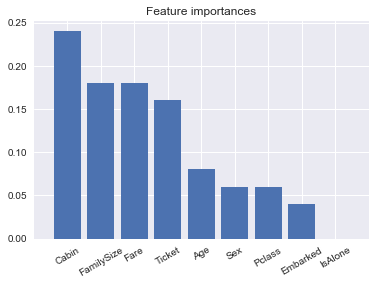

In [45]:
plot_importances(clf_ab, X_train.columns.values)

Both *Random Forest* and *Decision Tree* achieved the same score with the train data. Let's try a *Grid Search* to obtain the best set of parameters.

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = { 'criterion' : ['gini', 'entropy'], 
               'min_samples_leaf' : [1, 5, 10], 
               'min_samples_split' : [2, 4, 10, 12, 16], 
               'n_estimators': [50, 100, 400, 700, 1000]}
gs = GridSearchCV(estimator=clf_rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.820426487093
{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 50}


In [55]:
clf_rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=12, n_estimators=50)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=12, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [56]:
y_pred = clf_rf.predict(X_valid)

In [57]:
submission = pd.DataFrame({'PassengerId': df_ids, 'Survived': y_pred})
submission.to_csv('titanic-output.csv', index=False)